In [2]:
!pip install biopython
!pip install hdbscan
!pip install umap-learn
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 49.1 MB/s eta 0:00:00


In [4]:
from Bio import Entrez, SeqIO
import os
import pandas as pd

# Always provide your email to NCBI
Entrez.email = "megsss05@gmail.com"

# Revised search query to find more sequences
search_handle = Entrez.esearch(
    db="nucleotide",
    term="Cnidaria SSU rRNA",
    retmax=1000 # Increased the number of results to fetch
)
search_results = Entrez.read(search_handle)
id_list = search_results['IdList']
print(f"Found {len(id_list)} sequences.")

# Fetch the FASTA sequences and GenBank records for taxonomic info
fetch_handle = Entrez.efetch(
    db="nucleotide",
    id=id_list,
    rettype="gbwithparts", # Get GenBank records with parts
    retmode="xml"      # Get data in XML format
)
records = Entrez.read(fetch_handle)
fetch_handle.close()

# Save the data to a file in the Colab environment
fasta_file = "cnidaria_400.fasta"
with open(fasta_file, "w") as f:
    for record in records:
        # Extract sequence data and write to FASTA
        if 'GBSeq_sequence' in record:
            seq_id = record['GBSeq_locus']
            sequence = record['GBSeq_sequence'].upper()
            f.write(f">{seq_id}\n{sequence}\n")

print(f"FASTA file saved as {fasta_file}")

# Extract sequence and taxonomic information into a DataFrame
sequences_data = []
for record in records:
    seq_id = record.get('GBSeq_locus', record.get('GBSeq_accession'))
    sequence = record.get('GBSeq_sequence', '').upper()
    taxonomy = record.get('GBSeq_taxonomy', '').split('; ')
    organism = record.get('GBSeq_organism', '')

    sequences_data.append({
        'id': seq_id,
        'sequence': sequence,
        'taxonomy': taxonomy,
        'organism': organism
    })

sequences_df = pd.DataFrame(sequences_data)

print("\nPreview of sequences with taxonomic info:")
display(sequences_df.head())

Found 443 sequences.
FASTA file saved as cnidaria_400.fasta

Preview of sequences with taxonomic info:


,id,sequence,taxonomy,organism
0,LC777095,CTTTAATGGAGTGTGTTGGGCTAATTTTAGCCCACATACAATAGGC...,"[Eukaryota, Metazoa, Cnidaria, Myxozoa, Myxosp...",Kudoa neoscomberomori
1,LC777094,CTTTAATGGAGTGTGTTGGGCTTATTTTAGCCCACACACCTTAGGC...,"[Eukaryota, Metazoa, Cnidaria, Myxozoa, Myxosp...",Kudoa konishiae
2,LC777093,AATGGAAATAGTTATGTTCTTGATGAACATGAAGACATATGAATAA...,"[Eukaryota, Metazoa, Cnidaria, Myxozoa, Myxosp...",Kudoa lutjanus
3,OR951406,GGCGCGCAAATTACCCAATCCAGACAGTGGGAGGTGGTAACGAGAA...,"[Eukaryota, Metazoa, Cnidaria, Myxozoa, Myxosp...",Myxobolus sandrae
4,OR951405,GCGCAAATTACCCAATCCAGACAGTGGGAGGTGGTAACGAGAAGTA...,"[Eukaryota, Metazoa, Cnidaria, Myxozoa, Myxosp...",Myxobolus sandrae


In [5]:
import collections
from Bio import SeqIO
import numpy as np
import pandas as pd

def kmer_counts(sequence, k):
    """
    Generate a dictionary of k-mer counts for a DNA sequence.
    """
    counts = collections.defaultdict(int)
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k].upper()
        if 'N' not in kmer: # Exclude kmers with ambiguous nucleotides
            counts[kmer] += 1
    return counts

# Load sequences from the FASTA file
sequences_df = pd.DataFrame(columns=['id', 'sequence'])
fasta_file = "cnidaria_400.fasta"

for record in SeqIO.parse(fasta_file, "fasta"):
    new_row = {'id': record.id, 'sequence': str(record.seq).strip()}
    sequences_df.loc[len(sequences_df)] = new_row

# Generate k-mer features for all sequences
k = 4
kmer_features = []
for seq in sequences_df['sequence']:
    counts = kmer_counts(seq, k)
    kmer_features.append(counts)

# Create a DataFrame of the features
all_kmers = sorted(list(set(k for features in kmer_features for k in features)))
features_df = pd.DataFrame(kmer_features).fillna(0)
features_df = features_df.reindex(columns=all_kmers, fill_value=0)

print("K-mer feature matrix shape:", features_df.shape)
print("Preview of the feature matrix:")
print(features_df.head())

K-mer feature matrix shape: (443, 363)
Preview of the feature matrix:
   AAAA  AAAC  AAAG  AAAT  AACA  AACC  AACG  AACT  AACY  AAGA  ...  WCTG  \
0    14    11     9    10    14   6.0   3.0    11   0.0    12  ...   0.0   
1    14    13    11     6    15   7.0   4.0    12   0.0    10  ...   0.0   
2    23     5    20    14     8   3.0   1.0     3   0.0    18  ...   0.0   
3    10     8    10    13     4   1.0   8.0     5   0.0     4  ...   0.0   
4    10     8    10    13     4   1.0   8.0     5   0.0     4  ...   0.0   

   WGGC  WGTT  YAAC  YATA  YCGG  YCTG  YGGT  YGTG  YTGT  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 363 columns]


In [6]:
# Upgrade transformers to the latest version to fix potential import errors
!pip install --upgrade transformers torch

# Check if a GPU is available and use it
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 105.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0
Using device: cuda


In [7]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("fill-mask", model="zhihan1996/DNA_bert_5", trust_remote_code=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_bert.py:   0%|          | 0.00/807 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/zhihan1996/DNA_bert_5:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


dnabert_layer.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/zhihan1996/DNA_bert_5:
- dnabert_layer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/350M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/204 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie bert.embeddings.word_embeddings.weight to cls.predictions.decoder.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie cls.predictions.bias to cls.predictions.decoder.bias, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
BertForMaskedLM LOAD REPORT from: zhihan1996/DNA_bert_5
Key                      | Status     |  | 
-------------------------+------------+--+-
bert.pooler.dense.weight | UNEXPECTED |  | 
bert.pooler.dense.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [8]:
from transformers import BertModel, BertTokenizer

# Load the pre-trained DNABERT model and tokenizer using the correct name
# Model from: https://huggingface.co/zhihan1996/DNA_bert_6
tokenizer = BertTokenizer.from_pretrained("zhihan1996/DNA_bert_6", do_lower_case=False)
model = BertModel.from_pretrained("zhihan1996/DNA_bert_6").to(device)

print("DNABERT model and tokenizer loaded.")

tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/359M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/359M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: zhihan1996/DNA_bert_6
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.predictions.decoder.bias               | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


DNABERT model and tokenizer loaded.


In [10]:
# Assuming sequences_df with 'sequence' column is available from a previous cell (o_GKmg2ezg4Q)

def get_dnabert_embeddings(sequences, model, tokenizer, device, max_length=512, batch_size=8):
    """
    Generates DNABERT embeddings for a list of DNA sequences.
    Handles sequences longer than max_length by splitting.
    """
    model.eval() # Set the model to evaluation mode
    embeddings = []

    # Process in batches
    for i in range(0, len(sequences), batch_size):
        batch_sequences = sequences[i:i+batch_size]
        batch_embeddings = []

        for seq in batch_sequences:
            # DNABERT requires spacing between nucleotides like 'A T C G'
            spaced_seq = " ".join(list(seq.upper()))

            # Handle sequences longer than max_length (minus 2 for [CLS] and [SEP])
            # This is a simple splitting approach; more advanced methods exist
            if len(spaced_seq.split()) > max_length - 2:
                 # Split the sequence into chunks
                 tokens = spaced_seq.split()
                 chunks = [tokens[j:j + max_length - 2] for j in range(0, len(tokens), max_length - 2)]
                 chunk_embeddings = []
                 for chunk in chunks:
                      chunk_seq = " ".join(chunk)
                      inputs = tokenizer(chunk_seq, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
                      with torch.no_grad():
                          outputs = model(**inputs)
                      # Use the embedding of the [CLS] token (first token) as a sequence representation
                      chunk_embeddings.append(outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy())
                 # Average embeddings from chunks (simple aggregation)
                 seq_embedding = np.mean(chunk_embeddings, axis=0)

            else:
                # Process shorter sequences directly
                inputs = tokenizer(spaced_seq, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
                with torch.no_grad():
                    outputs = model(**inputs)
                # Use the embedding of the [CLS] token (first token)
                seq_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

            batch_embeddings.append(seq_embedding)

        embeddings.extend(batch_embeddings)

    # Convert list of numpy arrays to a single numpy array
    embeddings_array = np.array(embeddings)
    return embeddings_array

print("Generating DNABERT embeddings...")
dnabert_features = get_dnabert_embeddings(sequences_df['sequence'].tolist(), model, tokenizer, device)

# Convert numpy array to pandas DataFrame for consistency with previous steps
features_df_dnabert = pd.DataFrame(dnabert_features)

print("DNABERT feature matrix shape:", features_df_dnabert.shape)
print("Preview of the DNABERT feature matrix:")
display(features_df_dnabert.head())

# Now you would use features_df_dnabert for clustering (cell zplkHP3809vR) and UMAP (cell NwP73fla3M3Z)
# You will need to modify those cells to use features_df_dnabert instead of features_df (or features_df_local)

Generating DNABERT embeddings...
DNABERT feature matrix shape: (443, 768)
Preview of the DNABERT feature matrix:


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-1.228037,-0.337333,0.021945,-1.011391,-0.796651,-2.054818,0.082440,0.034447,-0.598358,-0.141259,...,1.274514,-0.067571,0.920098,-0.456442,0.774103,2.059841,-0.488224,-1.090765,-1.370262,-0.120397
1,-1.226909,-0.336779,0.020200,-1.012323,-0.797534,-2.055324,0.083958,0.033577,-0.598870,-0.140585,...,1.275529,-0.069092,0.920111,-0.454585,0.774986,2.061867,-0.488814,-1.091459,-1.370723,-0.118836
2,-1.226290,-0.336910,0.020712,-1.011755,-0.797784,-2.054600,0.082989,0.033980,-0.599344,-0.141436,...,1.275651,-0.069019,0.918886,-0.454371,0.777351,2.061496,-0.488329,-1.091568,-1.370551,-0.119067
3,-1.226736,-0.338615,0.019804,-1.012478,-0.795264,-2.049944,0.085249,0.036777,-0.598131,-0.139605,...,1.275174,-0.072958,0.927354,-0.460114,0.770737,2.062560,-0.486500,-1.094376,-1.370223,-0.121420
4,-1.228037,-0.337333,0.021945,-1.011391,-0.796651,-2.054818,0.082440,0.034447,-0.598358,-0.141259,...,1.274514,-0.067571,0.920098,-0.456442,0.774103,2.059841,-0.488224,-1.090765,-1.370262,-0.120397


In [11]:
# ==========================
# Cell 8: HDBSCAN Clustering
# ==========================

import hdbscan
import numpy as np

# Use DNABERT features for clustering
# Make sure to use the correct features dataframe (features_df_dnabert)
# features_to_cluster = features_df # Original k-mer features
features_to_cluster = features_df_dnabert # DNABERT features

# Convert to numpy array for HDBSCAN
data_for_clustering = features_to_cluster.values

# Apply HDBSCAN
min_cluster_size = 10  # Adjust based on your data and expected cluster sizes
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
clusterer.fit(data_for_clustering)

# Get cluster labels
cluster_labels = clusterer.labels_

# Number of clusters (excluding noise, labeled as -1)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

print(f"Number of clusters found (excluding noise): {n_clusters}")
print("Cluster labels assigned.")

# You can now use these cluster_labels in your UMAP visualization

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


Number of clusters found (excluding noise): 10
Cluster labels assigned.


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


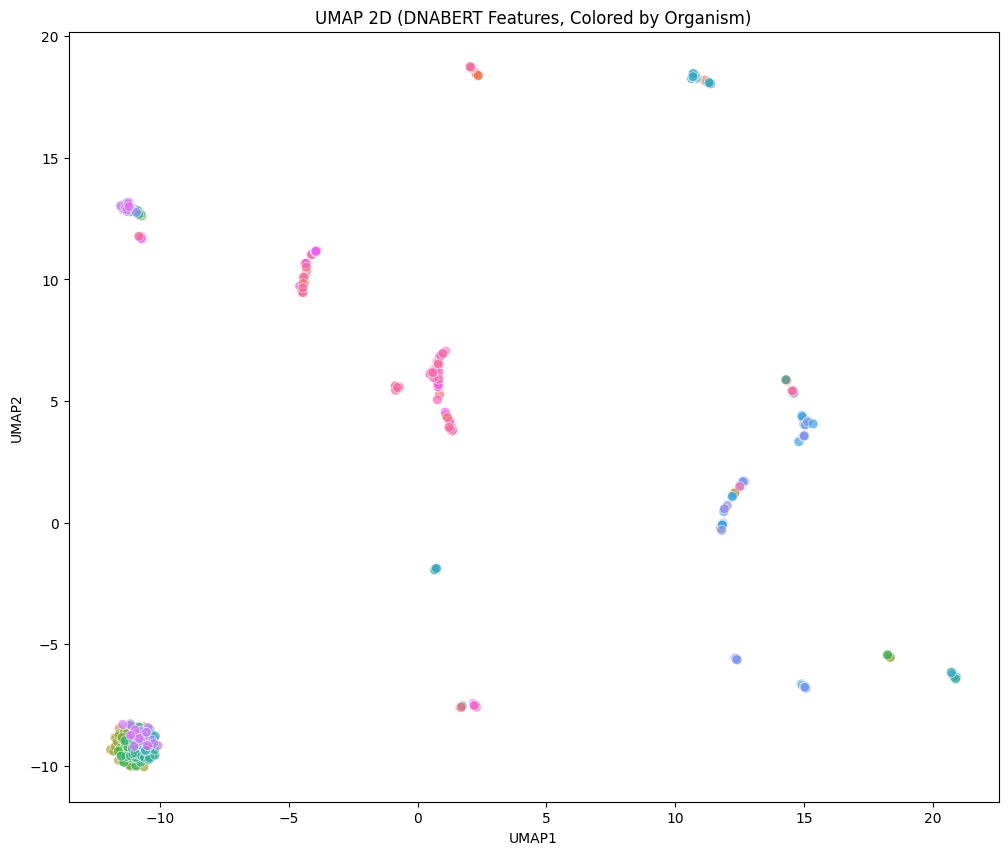

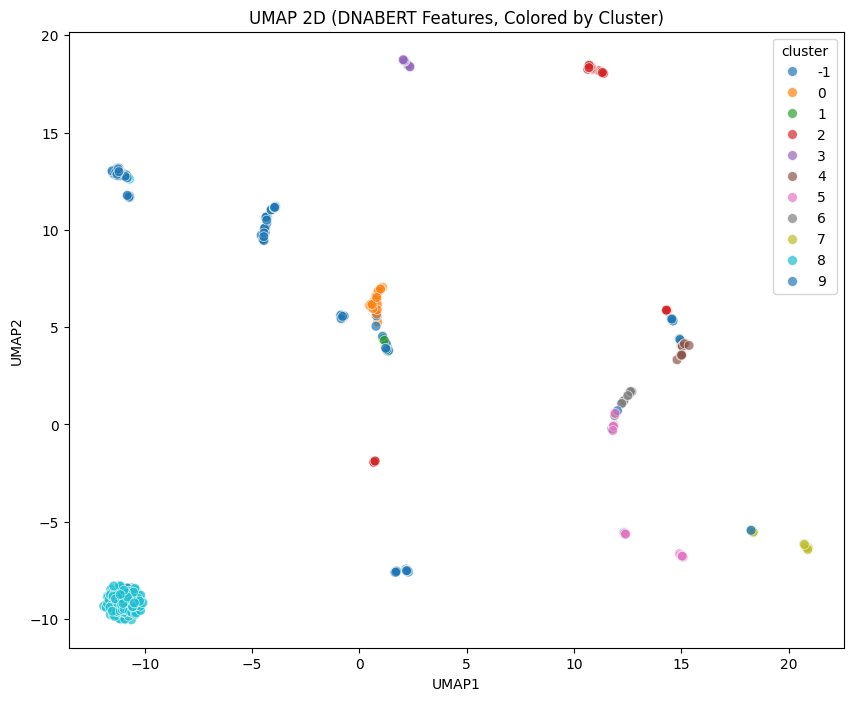

In [12]:
# ==========================
# Cell 10: UMAP Visualization (2D + 3D)
# ==========================

import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D projection

# --- Ensure data availability (reuse from previous steps) ---
try:
    if 'sequences_df_local' not in globals():
        sequences_data_local_full = []
        # Assuming 'records' is available from a previous cell
        for record in records:
            seq_id = record.get('GBSeq_locus', record.get('GBSeq_accession'))
            sequence = record.get('GBSeq_sequence', '').upper()
            taxonomy = record.get('GBSeq_taxonomy', '').split('; ')
            organism = record.get('GBSeq_organism', '')

            sequences_data_local_full.append({
                'id': seq_id,
                'sequence': sequence,
                'taxonomy': taxonomy,
                'organism': organism
            })
        sequences_df_local = pd.DataFrame(sequences_data_local_full)

except Exception as e:
    print(f"Error preparing sequences_df_local: {e}")
    # Depending on the error, you might want to handle this differently
    # For now, we'll just print and continue, assuming it's not critical
    # or that sequences_df_local is already defined.
    pass


# --- 2D UMAP ---
reducer_2d = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, metric='euclidean', random_state=42)
# Use the DNABERT features (features_df_dnabert) for UMAP
embedding_2d = reducer_2d.fit_transform(features_df_dnabert)

embedding_df = pd.DataFrame(embedding_2d, columns=['UMAP1', 'UMAP2'])
embedding_df['organism'] = sequences_df_local['organism'].reset_index(drop=True)
embedding_df['cluster'] = cluster_labels

# --- 3D UMAP ---
reducer_3d = umap.UMAP(n_neighbors=15, n_components=3, min_dist=0.1, metric='euclidean', random_state=42)
# Use the DNABERT features (features_df_dnabert) for UMAP
embedding_3d = reducer_3d.fit_transform(features_df_dnabert)

embedding_df_3d = pd.DataFrame(embedding_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'])
embedding_df_3d['organism'] = sequences_df_local['organism'].reset_index(drop=True)
embedding_df_3d['cluster'] = cluster_labels

# ====================
# 2D Plot - Colored by Organism
# ====================
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x="UMAP1", y="UMAP2",
    hue="organism",
    data=embedding_df,
    legend=False,  # Hide legend if too many organisms
    s=50, alpha=0.7
)
plt.title('UMAP 2D (DNABERT Features, Colored by Organism)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

# ====================
# 2D Plot - Colored by Cluster
# ====================
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="UMAP1", y="UMAP2",
    hue="cluster",
    palette="tab10",
    data=embedding_df,
    legend="full",
    s=50, alpha=0.7
)
plt.title('UMAP 2D (DNABERT Features, Colored by Cluster)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

# ====================
# 3D Plot - Colored by Organism (Plotly)
# ====================
import plotly.express as px

fig = px.scatter_3d(
    embedding_df_3d,
    x='UMAP1', y='UMAP2', z='UMAP3',
    color='organism',
    title='UMAP 3D (DNABERT Features, Colored by Organism)',
    opacity=0.7,
    symbol='organism'  # optional: different shapes for organisms
)
fig.update_traces(marker=dict(size=5))
fig.show()

# ====================
# 3D Plot - Colored by Cluster (Plotly)
# ====================
fig = px.scatter_3d(
    embedding_df_3d,
    x='UMAP1', y='UMAP2', z='UMAP3',
    color='cluster',
    title='UMAP 3D (DNABERT Features, Colored by Cluster)',
    opacity=0.7,
    symbol='cluster'  # optional: different shapes per cluster
)
fig.update_traces(marker=dict(size=5))
fig.show()

In [13]:
# Code to analyze the taxonomic composition of each cluster (re-generated)
# Assuming embedding_df with 'cluster' and 'organism' columns is available
# Assuming sequences_df (or sequences_df_local from NwP73fla3M3Z) with 'organism' and 'taxonomy' is available

# --- User Input: Specify the cluster ID you want to investigate (optional) ---
# You can leave this as None to see the overall composition table, or set it to a cluster ID
cluster_id_to_investigate = 4 # <-- Set this to a cluster ID (e.g., 15) for detailed view

print("\nAnalyzing taxonomic composition of each cluster:")

# Ensure we have the necessary dataframes and columns
if 'embedding_df' in locals() or 'embedding_df' in globals():
    if 'cluster' in embedding_df.columns and 'organism' in embedding_df.columns:
        # Attempt to find the dataframe with full taxonomy
        if 'sequences_df_local' in locals() or 'sequences_df_local' in globals():
             sequences_df_with_taxonomy = sequences_df_local # Use the local one if available
        elif 'sequences_df' in locals() or 'sequences_df' in globals():
             sequences_df_with_taxonomy = sequences_df # Otherwise, use the global one


        if 'organism' in sequences_df_with_taxonomy.columns and 'taxonomy' in sequences_df_with_taxonomy.columns:

            # Create a combined dataframe for analysis
            # Merge with the dataframe containing full taxonomy based on index, which is more reliable
            # Ensure both dataframes have their original index available for merging
            combined_analysis_df = pd.merge(
                embedding_df[['cluster', 'organism']].reset_index(), # Include original index and relevant embedding info
                sequences_df_with_taxonomy[['organism', 'taxonomy']].reset_index(), # Include original index and relevant taxonomy info
                on='index', # Merge based on the original row index
                how='left'
            ).drop(columns=['index']) # Drop the index column after merging

            # Handle potential duplicate organism names leading to duplicated rows after merge
            # The merge on index should prevent this, but let's clean up columns just in case
            if 'organism_x' in combined_analysis_df.columns:
                 combined_analysis_df = combined_analysis_df.rename(columns={'organism_x': 'organism'})
            if 'organism_y' in combined_analysis_df.columns:
                 combined_analysis_df = combined_analysis_df.drop(columns=['organism_y'])


            # Convert the 'taxonomy' list to a tuple to make it hashable for drop_duplicates if needed later
            if 'taxonomy' in combined_analysis_df.columns:
                 combined_analysis_df['taxonomy_tuple'] = combined_analysis_df['taxonomy'].apply(tuple)


            # --- Perform Analysis ---

            if cluster_id_to_investigate is not None:
                 # Detailed analysis for a specific cluster
                 print(f"\nDetailed Analysis for Cluster {cluster_id_to_investigate}:")
                 cluster_sequences_df = combined_analysis_df[combined_analysis_df['cluster'] == cluster_id_to_investigate]

                 if not cluster_sequences_df.empty:

                      # Drop duplicate rows based on organism and taxonomy for the display list
                      subset_cols_for_drop = []
                      if 'organism' in cluster_sequences_df.columns:
                          subset_cols_for_drop.append('organism')
                      if 'taxonomy_tuple' in cluster_sequences_df.columns: # Use the tuple version for dropping duplicates
                          subset_cols_for_drop.append('taxonomy_tuple')
                      elif 'taxonomy' in cluster_sequences_df.columns: # Fallback if tuple wasn't created
                           subset_cols_for_drop.append('taxonomy')


                      if subset_cols_for_drop:
                          display_df = cluster_sequences_df.drop_duplicates(subset=subset_cols_for_drop)
                          print(f"Showing unique organism/taxonomy combinations in Cluster {cluster_id_to_investigate}.")
                      else:
                           display_df = cluster_sequences_df # Show all if cannot drop duplicates
                           print("Cannot drop duplicates, showing all entries in cluster.")


                      # Display the organism counts within this cluster
                      print(f"\nOrganism counts within Cluster {cluster_id_to_investigate}:")
                      display(cluster_sequences_df['organism'].value_counts()) # Use the full cluster data for counts

                      # Display the full list of unique organisms and their taxonomies in this cluster
                      print(f"\nUnique Organisms and Taxonomies within Cluster {cluster_id_to_investigate}:")
                      # Select relevant columns from the display dataframe
                      display(display_df[['organism', 'taxonomy']])

                 else:
                     print(f"Cluster {cluster_id_to_investigate} is empty or does not exist.")

            else:
                 # Overall composition table for all clusters
                 print("\nOverall Taxonomic Composition Table (Organism counts per Cluster):")
                 cluster_composition = combined_analysis_df.groupby('cluster')['organism'].value_counts().unstack(fill_value=0)

                 # Calculate the total number of sequences in each cluster
                 cluster_sizes = combined_analysis_df['cluster'].value_counts()

                 # Add cluster sizes as a column (optional, but helpful)
                 cluster_composition['Total in Cluster'] = cluster_sizes

                 # Sort by cluster index
                 cluster_composition = cluster_composition.sort_index()

                 # Display the overall composition table
                 display(cluster_composition) # Standard view

                 # Print the dominant organism for each cluster (excluding noise)
                 print("\nDominant organism in each non-noise cluster:")
                 for cluster_id in cluster_composition.index:
                    if cluster_id != -1: # Exclude noise cluster
                        # Get the counts for the current cluster, excluding the 'Total in Cluster' column
                        organism_counts = cluster_composition.loc[cluster_id].drop('Total in Cluster')
                        # Find the organism with the maximum count in this cluster
                        dominant_organism = organism_counts.idxmax()
                        dominant_count = organism_counts.max()
                        total_in_cluster = cluster_composition.loc[cluster_id, 'Total in Cluster']

                        if total_in_cluster > 0: # Avoid division by zero if a cluster somehow ended up with 0 total
                             print(f"Cluster {cluster_id}: {dominant_organism} ({dominant_count}/{total_in_cluster})")
                        else:
                             print(f"Cluster {cluster_id}: Empty cluster")


        else:
             print("Required columns ('organism' or 'taxonomy') not found in the sequences dataframe with taxonomy.")
    else:
        print("Required columns ('cluster' or 'organism') not found in the embedding dataframe.")
else:
    print("Embedding DataFrame (embedding_df) not found. Please run the UMAP cell (NwP73fla3M3Z) first.")


Analyzing taxonomic composition of each cluster:

Detailed Analysis for Cluster 4:
Showing unique organism/taxonomy combinations in Cluster 4.

Organism counts within Cluster 4:


,count
organism,
Acropora microclados,2
Acropora abrotanoides,2
Isopora cuneata,1
Acropora granulosa,1
Acropora vaughani,1
Acropora cytherea,1
Isopora brueggemanni,1
Acropora chesterfieldensis,1
Acropora polystoma,1



Unique Organisms and Taxonomies within Cluster 4:


,organism,taxonomy
260,Isopora brueggemanni,"[Eukaryota, Metazoa, Cnidaria, Anthozoa, Hexac..."
262,Isopora cuneata,"[Eukaryota, Metazoa, Cnidaria, Anthozoa, Hexac..."
269,Acropora granulosa,"[Eukaryota, Metazoa, Cnidaria, Anthozoa, Hexac..."
271,Acropora vaughani,"[Eukaryota, Metazoa, Cnidaria, Anthozoa, Hexac..."
272,Acropora microclados,"[Eukaryota, Metazoa, Cnidaria, Anthozoa, Hexac..."
274,Acropora cytherea,"[Eukaryota, Metazoa, Cnidaria, Anthozoa, Hexac..."
278,Acropora chesterfieldensis,"[Eukaryota, Metazoa, Cnidaria, Anthozoa, Hexac..."
282,Acropora abrotanoides,"[Eukaryota, Metazoa, Cnidaria, Anthozoa, Hexac..."
287,Acropora polystoma,"[Eukaryota, Metazoa, Cnidaria, Anthozoa, Hexac..."
299,Acropora paniculata,"[Eukaryota, Metazoa, Cnidaria, Anthozoa, Hexac..."


In [14]:
# ==========================
# Cell 9: Clustering Evaluation Metrics
# ==========================

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

print("\n==============================")
print("Clustering Evaluation Metrics")
print("==============================")

try:
    # Ensure required variables exist
    if 'cluster_labels' not in globals():
        raise NameError("cluster_labels not found. Run clustering cell first.")

    if 'features_df_dnabert' not in globals():
        raise NameError("features_df_dnabert not found. Run embedding cell first.")

    # Convert features to numpy
    feature_matrix = features_df_dnabert.values
    labels = np.array(cluster_labels)

    # Remove noise points (-1) for evaluation
    non_noise_mask = labels != -1
    filtered_features = feature_matrix[non_noise_mask]
    filtered_labels = labels[non_noise_mask]

    n_clusters = len(set(filtered_labels))

    print(f"Total clusters (excluding noise): {n_clusters}")
    print(f"Total samples used for evaluation: {len(filtered_labels)}")

    # Silhouette Score
    if n_clusters >= 2 and len(filtered_labels) >= 3:
        sil_score = silhouette_score(filtered_features, filtered_labels)
        print(f"\nSilhouette Score (excluding noise): {sil_score:.4f}")
    else:
        print("\nSilhouette Score: Not enough valid clusters to compute.")

    # Davies-Bouldin Index
    if n_clusters >= 2:
        db_score = davies_bouldin_score(filtered_features, filtered_labels)
        print(f"Davies-Bouldin Index (excluding noise): {db_score:.4f}")
    else:
        print("Davies-Bouldin Index: Not enough valid clusters to compute.")

    # Calinski-Harabasz Score (Optional but recommended)
    if n_clusters >= 2:
        ch_score = calinski_harabasz_score(filtered_features, filtered_labels)
        print(f"Calinski-Harabasz Score (excluding noise): {ch_score:.4f}")
    else:
        print("Calinski-Harabasz Score: Not enough valid clusters to compute.")

except Exception as e:
    print(f"Error computing clustering metrics: {e}")


Clustering Evaluation Metrics
Total clusters (excluding noise): 10
Total samples used for evaluation: 354

Silhouette Score (excluding noise): 0.8201
Davies-Bouldin Index (excluding noise): 0.4434
Calinski-Harabasz Score (excluding noise): 2939.3970


In [20]:
import plotly.express as px

fig_organism_3d = px.scatter_3d(
    embedding_df_3d,
    x='UMAP1',
    y='UMAP2',
    z='UMAP3',
    color='organism',
    title='UMAP 3D (DNABERT Features, Colored by Organism)',
    opacity=0.7,
    symbol='organism'
)

fig_organism_3d.update_traces(marker=dict(size=5))
fig_organism_3d.show()

In [21]:
fig_cluster_3d = px.scatter_3d(
    embedding_df_3d,
    x='UMAP1',
    y='UMAP2',
    z='UMAP3',
    color='cluster',
    title='UMAP 3D (DNABERT Features, Colored by Cluster)',
    opacity=0.7,
    symbol='cluster'
)

fig_cluster_3d.update_traces(marker=dict(size=5))
fig_cluster_3d.show()

In [22]:
with open("umap_all_3d_plots.html", "w") as f:
    f.write(fig_organism_3d.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig_cluster_3d.to_html(full_html=False, include_plotlyjs=False))

In [23]:
from google.colab import files
files.download("umap_all_3d_plots.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>